## TESTE TÉCNICO DATA SCIENCE
#2) Modelagem - Redes Neurais 
## <span style="color:darkred">Rômulo Róseo Rebouças</span>

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Sequential

import numpy as np
import pandas as pd
import matplotlib

# **RNN com base de dados sem tratamento de balanceamento**

In [2]:
##-- Leitua Cadastro sem balanceamento
df = pd.read_pickle('bd_SemBalanceamento.pkl') 
df

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_cod,room_type_tgt
0,221,5,260,1,304,32,0
1,307,3,85,1,10,62,0
2,160,7,238,11,328,32,0
3,273,2,181,1,207,62,0
4,135,3,353,1,101,32,0
...,...,...,...,...,...,...,...
26609,763,1,0,61,327,62,0
26610,94,1,0,4,180,109,2
26611,141,1,0,1,365,28,0
26613,160,5,0,3,269,132,0


In [3]:
####
print(df['room_type_tgt'].unique())
print(df.shape)

rotulos = np.array(df['room_type_tgt'])
features = np.array(df.iloc[:, 0:-1])

[0 2 3 1]
(23845, 7)


In [4]:
##-- Separando os dados:

perc_train = 0.7

n_train = int(features.shape[0]*perc_train)
n_test = int(features.shape[0]*(1-perc_train))

x_train =  features[0:n_train,:]
y_train = rotulos[0:n_train]

x_test =  features[0:n_test,:]
y_test = rotulos[0:n_test]

# transformar categorias em one-hot-encoding
y_train = keras.utils.to_categorical(y_train, 4)
y_test = keras.utils.to_categorical(y_test, 4)

print("\nConj. Train: ", len(x_train))
print("Conj. Y Train : ", len(x_train))
print("\nConj. Test ", len(x_test))
print("Conj. Y Test : ", len(y_test))


Conj. Train:  16691
Conj. Y Train :  16691

Conj. Test  7153
Conj. Y Test :  7153


In [5]:
##-- Rede neural profunda
def model_rnn (input_shape, dropout_rate=0.0):
    
    inputs = keras.Input(shape=input_shape)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(4, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [6]:
input_shape = 6

model = model_rnn(input_shape , 0.2)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160  

In [7]:
##-- inicializando e treinando  
##-- Taxa de aprendizado inicial de 0.001 e com decaimento em todas as épocas exponencial a -0.3
seed(1)
set_seed(2)

def scheduler(epoch, lr):
    return np.clip(lr * tf.math.exp(-0.3), 0.00001, 0.001)
    
callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

##-- Uso de pesos para as classes: menor peso para classes majoritárias (0 e 2) e maior peso para classes minoritárias (1 e 3)
class_weight = {0: 0.5, 1: 0.7, 2: 0.5, 3: 0.9}

epochs = 20
batch_size = 16

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=[tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 'accuracy'] )
##-- Conjunto
hist_bdnormal = model.fit(x_train, y_train, class_weight=class_weight,
             callbacks=[callbacklr], batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
1044/1044 [==============================] - 6s 4ms/step - loss: 0.3764 - precision: 0.7509 - recall: 0.6508 - accuracy: 0.7258
Epoch 2/20
1044/1044 [==============================] - 4s 4ms/step - loss: 0.3351 - precision: 0.7541 - recall: 0.6929 - accuracy: 0.7346
Epoch 3/20
1044/1044 [==============================] - 4s 4ms/step - loss: 0.3229 - precision: 0.7693 - recall: 0.7131 - accuracy: 0.7526
Epoch 4/20
1044/1044 [==============================] - 4s 4ms/step - loss: 0.3147 - precision: 0.7753 - recall: 0.7285 - accuracy: 0.7591
Epoch 5/20
1044/1044 [==============================] - 4s 4ms/step - loss: 0.3247 - precision: 0.7699 - recall: 0.7171 - accuracy: 0.7549
Epoch 6/20
1044/1044 [==============================] - 4s 4ms/step - loss: 0.3119 - precision: 0.7774 - recall: 0.7292 - accuracy: 0.7581
Epoch 7/20
1044/1044 [==============================] - 4s 4ms/step - loss: 0.3069 - precision: 0.7792 - recall: 0.7345 - accuracy: 0.7627
Epoch 8/20
1044/1044 [=====

In [8]:
hist_bdnormal_t = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    verbose=0)

score1_Tr = model.evaluate(x_train, y_train, verbose = 0)
score1_Te = model.evaluate(x_test, y_test, verbose = 0)

# **RNN com Balanceamento SMOTEENN (combinado)**

In [9]:
##-- Leitua Cadastro com balanceamento - SMOTEENN (combinado)
df = pd.read_pickle('bd_SMOTEENN_Comb.pkl') 
df

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_cod,room_type_tgt
0,-0.439785,0.025927,7.947134,-0.233806,0.629464,-0.569045,0
1,-0.089480,-0.079835,2.309906,-0.233806,-1.457292,0.264563,0
2,-0.790090,-0.079835,10.942918,-0.233806,-0.811392,-0.569045,0
3,0.631497,-0.079835,0.151653,-0.205984,1.062430,-0.569045,0
4,0.859602,-0.026954,-0.299325,-0.205984,-1.521172,-0.569045,0
...,...,...,...,...,...,...,...
16715,-0.689149,-0.185597,-0.428176,-0.168618,1.062430,0.156860,3
16716,-1.062020,-0.184068,0.091574,0.069292,-0.622966,-1.064389,3
16717,-1.107337,-0.123399,-0.394072,-0.225636,0.982258,-1.069210,3
16718,-0.342816,0.007891,-0.422683,-0.081105,-0.374629,-0.569045,3


In [10]:
####
print(df['room_type_tgt'].unique())
print(df.shape)

rotulos = np.array(df['room_type_tgt'])
features = np.array(df.iloc[:, 0:-1])

[0 1 2 3]
(16720, 7)


In [11]:
##-- Separando os dados:

perc_train = 0.7

n_train = int(features.shape[0]*perc_train)
n_test = int(features.shape[0]*(1-perc_train))

x_train =  features[0:n_train,:]
y_train = rotulos[0:n_train]

x_test =  features[0:n_test,:]
y_test = rotulos[0:n_test]

# transformar categorias em one-hot-encoding
y_train = keras.utils.to_categorical(y_train, 4)
y_test = keras.utils.to_categorical(y_test, 4)

print("\nConj. Train: ", len(x_train))
print("Conj. Y Train : ", len(x_train))
print("\nConj. Test ", len(x_test))
print("Conj. Y Test : ", len(y_test))


Conj. Train:  11704
Conj. Y Train :  11704

Conj. Test  5016
Conj. Y Test :  5016


In [12]:
input_shape = 6

model_bdBal = model_rnn(input_shape , 0.2)
model_bdBal.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6)                 24        
_________________________________________________________________
dense_5 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160

In [13]:
##-- inicializando e treinando  
##-- Taxa de aprendizado inicial de 0.001 e com decaimento em todas as épocas exponencial a -0.3
seed(1)
set_seed(2)

def scheduler(epoch, lr):
    return np.clip(lr * tf.math.exp(-0.3), 0.00001, 0.001)
    
callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

##-- Uso de pesos para as classes: menor peso para classes majoritárias (0 e 2) e maior peso para classes minoritárias (1 e 3)
class_weight = {0: 0.5, 1: 0.7, 2: 0.5, 3: 0.9}

epochs = 20
batch_size = 16

model_bdBal.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=[tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 'accuracy'] )
##-- Conjunto
hist_bdBal = model_bdBal.fit(x_train, y_train, class_weight=class_weight,
             callbacks=[callbacklr], batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
732/732 [==============================] - 4s 4ms/step - loss: 0.3101 - precision: 0.8319 - recall: 0.7276 - accuracy: 0.7953
Epoch 2/20
732/732 [==============================] - 3s 4ms/step - loss: 0.2041 - precision: 0.8800 - recall: 0.8603 - accuracy: 0.8699
Epoch 3/20
732/732 [==============================] - 3s 4ms/step - loss: 0.1829 - precision: 0.8987 - recall: 0.8831 - accuracy: 0.8916
Epoch 4/20
732/732 [==============================] - 3s 4ms/step - loss: 0.1746 - precision: 0.8961 - recall: 0.8808 - accuracy: 0.8893
Epoch 5/20
732/732 [==============================] - 3s 4ms/step - loss: 0.1777 - precision: 0.8936 - recall: 0.8782 - accuracy: 0.8847
Epoch 6/20
732/732 [==============================] - 3s 4ms/step - loss: 0.1799 - precision: 0.8952 - recall: 0.8798 - accuracy: 0.8875
Epoch 7/20
732/732 [==============================] - 3s 4ms/step - loss: 0.1782 - precision: 0.8982 - recall: 0.8847 - accuracy: 0.8916
Epoch 8/20
732/732 [=====================

In [14]:
hist_bdBalanc_t = model_bdBal.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    verbose=0)

score1_TrBal = model_bdBal.evaluate(x_train, y_train, verbose = 0)
score1_TeBal = model_bdBal.evaluate(x_test, y_test, verbose = 0)

# **Resulta da RNN considerando a base de dados normal *versus* a RNN com base de dados com o tratamento do Balanceamento SMOTEENN (hibrido)**

Text(0.5, 1.0, 'Treinamento BD Normal x BD com Balanceamento Hibrido')

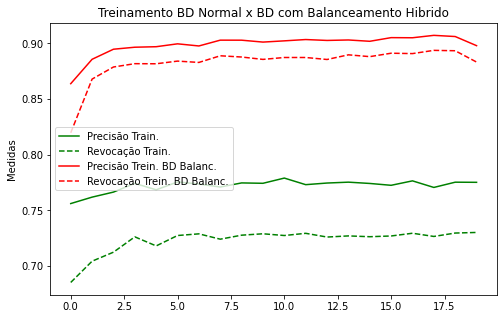

In [15]:
##-- Gráfico da precisão e revocação no treinamento S e teste T
plt.figure(figsize=(8,5))
plt.plot(hist_bdnormal.history['precision'], 'g')
plt.plot(hist_bdnormal.history['recall'], 'g--')
plt.plot(hist_bdBal.history['precision'], 'r')
plt.plot(hist_bdBal.history['recall'], 'r--')
plt.ylabel('Medidas' )
plt.legend(["Precisão Train.", "Revocação Train.", "Precisão Trein. BD Balanc.", "Revocação Trein. BD Balanc."], loc="best")
plt.title('Treinamento BD Normal x BD com Balanceamento Hibrido')

#### >> Houve ganho significativo com o tramento da base com balanceamento Smoteenn (hibrido) com a utilização da rede neural.

In [16]:
print("Acurácia treinamento - BD Normal: %.4f" % (score1_Tr[1]))
print("Acurácia teste - BD Normal: %.4f" % (score1_Te[1]))

print("Acurácia treinamento - BD Balanc.: %.4f" % (score1_TrBal[1]))
print("Acurácia teste - BD Balanc.: %.4f" % (score1_TeBal[1]))

Acurácia treinamento - BD Normal: 0.7647
Acurácia teste - BD Normal: 0.7634
Acurácia treinamento - BD Balanc.: 0.8978
Acurácia teste - BD Balanc.: 0.9956
